In [164]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
from tqdm import tqdm
import pandas as pd
import random
import ast
import pprint
import string
import nltk
import spacy
lemmatize = spacy.load('en_core_web_sm')

pp = pprint.PrettyPrinter(indent=4)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [165]:
df = pd.read_csv('/Users/sid/Desktop/Sem 6/ELL884/ELL884-a1/a1-data/train.csv') # loading training data
data = []
for index, row in tqdm(df.iterrows()):
    data.append(ast.literal_eval(row['tagged_sentence'])) # changing data-type of entries from 'str' to 'list'
    

47340it [00:05, 8095.96it/s] 


In [166]:
df = pd.read_csv('/Users/sid/Desktop/Sem 6/ELL884/ELL884-a1/a1-data/test_small.csv') # loading test data
test_data = {} 
for index, row in tqdm(df.iterrows()):
    test_data[row['id']] = ast.literal_eval(row['untagged_sentence']) # changing data-type of entries from 'str' to 'list'

4000it [00:00, 17158.09it/s]


In [167]:
def display_data(sentence_index):
    '''
        Input : 'sentence_index' (int) -> index of a sentence in training data
        Output: None
    '''
    sentence = data[sentence_index]
    print("TOKEN -> TAG")
    print('...')
    for token, tag in sentence:
        print(token, '>', tag)
sentence_index = random.choice(range(len(data)))

display_data(sentence_index)

TOKEN -> TAG
...
He > PP
did > DO
not > *
let > VB
the > AT
strings > NN
, > ,
for > IN
instance > NN
, > ,
weep > VB
, > ,
whine > VB
or > CC
get > VB
hysterical > JJ
. > .


In [168]:
# cell to create vocabulary of words
words = []

for sentence in data:
    for word,tag in sentence:
        words.append(word)
        
vocabulary = list(set(words))
V = len(vocabulary)

word_mapping = {}
j = 0
for word in vocabulary:
    word_mapping[word] = j
    j+=1
j = 0  

In [169]:
# cell to show the frequency of each distinct (slack or native) present in the training data
from collections import Counter
distinct_tags = []
word_tags = []
def store_tags():
    
    global distinct_tags
    global word_tags

    for sentence in data:
        for word, tag in sentence:
            word_tags.append((word, tag))
       
    
store_tags()

# find how many tags are there and how many times each tag occurs
tags = []
for word, tag in word_tags:
    tags.append(tag)  
distinct_tags=list(set(tags))
count_tags = {}
for tag, count in Counter(tags).items():
    count_tags[tag] = count

T = len(distinct_tags)

tag_mapping = {}

reverse_tag_mapping = {}
for idx,tag in enumerate(list(distinct_tags)):
    tag_mapping[tag] = idx
    reverse_tag_mapping[idx] = tag

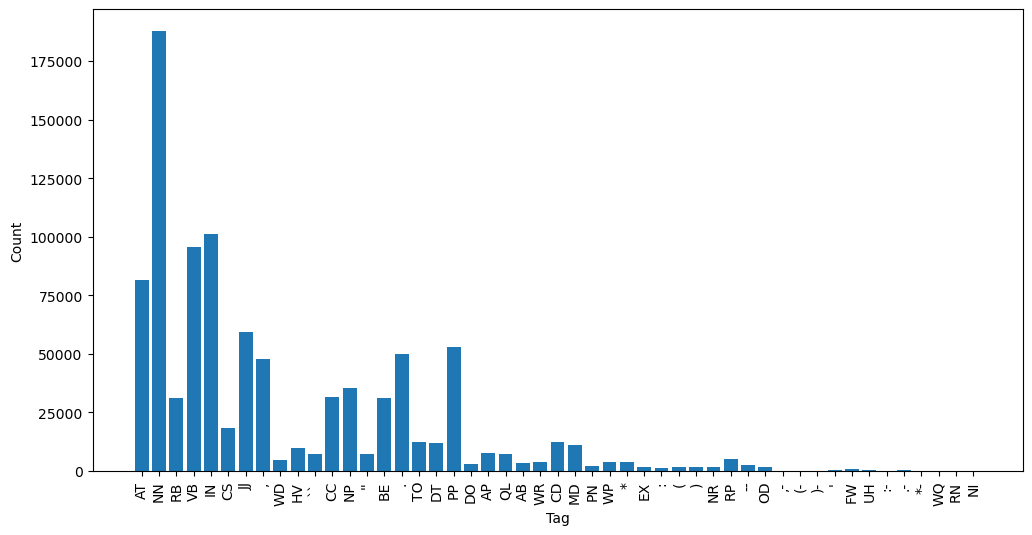

In [170]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
plt.bar(range(len(count_tags)), list(count_tags.values()), align='center')
plt.xticks(range(len(count_tags)), list(count_tags.keys()))
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

In [171]:
# calculate the prior probabilities (smoothed) of each state
smoothing_const = 0.1
pi = np.ones(T,dtype=float) * smoothing_const
for sentence in data:
    first_word, first_tag = sentence[0]
    pi[tag_mapping[first_tag]] += 1
    
pi /= np.sum(pi)

Add-k Smoothing

In [172]:
# A is transition probability matrix
# B is observation likelihood matrix
A = np.zeros((T,T),dtype='float64') * smoothing_const       # initialise with ones for smoothing
B = np.ones((T,V),dtype='float64') * smoothing_const       # use add-k smoothing 

# calculate transition probabilities
for idx,(word1, tag1) in enumerate(word_tags):
    if idx != len(word_tags)-1:
        word2, tag2 = word_tags[idx+1]
        A[tag_mapping[tag1]][tag_mapping[tag2]] += 1
    else:
        A[tag_mapping[tag1]][tag_mapping[tag1]] += 1
            
# calculate observation likelihoods
for word, tag in word_tags:
    B[tag_mapping[tag]][word_mapping[word]] += 1
 
print(A[tag_mapping['NN']][tag_mapping['NN']])

# normalise the rows    
for i in range(T):
    A[i]/= np.sum(A[i])

for i in range(T):
    B[i]/= np.sum(B[i])
    
print(A[tag_mapping['NN']][tag_mapping['NN']])

19462.0
0.10367623948561414


In [173]:
# function to decode the most probable sequence of states given a sequence of observations
def viterbi_decoder(sentence):
    
    n = len(sentence)
    first_word = sentence[0]
    
    # initialise the 1st layer of state probabilities and the backpointer (will be helpful for tracing back the best sequence of states)
    viterbi = np.zeros((T,n),dtype='float64')
    backpointer = np.zeros((T,n),dtype=int)
    
    for tag in range(T):
        if first_word in vocabulary:
            first_probability =  B[tag][word_mapping[first_word]]
        else:
            # use lemmatisation to handle OOV words
            first_lemma = lemmatize(first_word)[0].lemma_
            if first_lemma in vocabulary:
                first_probability = B[tag][word_mapping[first_lemma]]
            else:
                first_probability = 1e-6 

            
        viterbi[tag][0] = pi[tag]*first_probability
        backpointer[tag][0] = -1
        
    for key in range(1,n):
        for tag in range(T):
            if sentence[key] in vocabulary:
                emission_probability = B[tag][word_mapping[sentence[key]]]
            else:
                # use lemmatisation to handle OOV words
                lemma = lemmatize(sentence[key])[0].lemma_
                if lemma in vocabulary:
                    emission_probability = B[tag][word_mapping[lemma]]
                else:
                    emission_probability = 1e-6

            # calculate all possible probabilities for the current state   
            possible_probabilities = np.zeros(T)
            for sample_tag in range(T):
                possible_probabilities[sample_tag] += (viterbi[sample_tag][key-1]*A[sample_tag][tag]*emission_probability)

            # update the viterbi and backpointer matrices
            viterbi[tag][key] += possible_probabilities.max()
            backpointer[tag][key] = possible_probabilities.argmax()
            
    
    tagged_sentence = []
    end_ptr = int(viterbi[:,-1].argmax())
 
    tagged_sentence = []

    # trace back the best sequence of states
    time = n-1
    while end_ptr != -1:
        tagged_sentence.append((sentence[time],reverse_tag_mapping[end_ptr]))
        end_ptr = int(backpointer[end_ptr][time])
        time -= 1
       
    for i in range(n//2):
        tagged_sentence[i], tagged_sentence[-1 - i] = tagged_sentence[-1 - i], tagged_sentence[i]
    
    
    return tagged_sentence

pprint.pprint(viterbi_decoder(['Ayush',"plays",'football','in','the','park','with','yasaswani','and','harshitha','.']))

[('Ayush', 'PP'),
 ('plays', 'VB'),
 ('football', 'NN'),
 ('in', 'IN'),
 ('the', 'AT'),
 ('park', 'NN'),
 ('with', 'IN'),
 ('yasaswani', 'NN'),
 ('and', 'CC'),
 ('harshitha', 'NN'),
 ('.', '.')]


MEMM Tagger

In [128]:
training_sentences = [[] for i in range(len(data))]
training_tags = [[] for i in range(len(data))]
for idx, sentence in enumerate(data):
    for word, tag in sentence:
        training_sentences[idx].append(word)
        training_tags[idx].append(tag_mapping[tag])
      
training_data = []
for i in range(len(data)):
    training_data.append((training_sentences[i], training_tags[i]))
    
training_data = np.asarray(training_data, dtype='object')
print(training_data.shape)


# Split training_data into 1479 batches of size 32/33
batch_data = np.array_split(training_data, 1479)


(47340, 2)


In [129]:
# special tag
spl = -1

# get the history for predicting the current tag
# the history is a 4-tuple
# It consists of the previous 2 tags, the entire sentence and the position of the current tag
def create_history(sentence, tag_seq, pos):
    n = len(sentence)
    if (n==0):
        return (spl,spl,sentence,0)
    elif (n==1):
        if pos == 0:
            return (spl,spl,sentence,pos)
        else:
            return (spl,tag_seq[pos-1],sentence,pos)
    else:
        if (pos == 0):
            return (spl,spl,sentence,0)
        elif (pos == 1):
            return (spl,tag_seq[pos-1],sentence,pos)
        else:
            return (tag_seq[pos-2],tag_seq[pos-1],sentence,pos)

In [130]:
# cell to create the feature vector for each word in the sentence

# dimension of the feature and parameter vector
d = 50

def features(history, tag):
    feat = np.zeros(d)
    
    # Extracting context words
    word = history[2][history[3]]
    prev_word = history[2][history[3]-1] if history[3] > 0 else ''
    next_word = history[2][history[3]+1] if history[3] < len(history[2])-1 else ''
    prev_prev_word = history[2][history[3]-2] if history[3] > 1 else ''
    next_next_word = history[2][history[3]+2] if history[3] < len(history[2])-2 else ''
    
    # Context features
    feat[0] = 1 if prev_word else 0
    feat[1] = 1 if next_word else 0
    feat[2] = 1 if prev_prev_word else 0
    feat[3] = 1 if next_next_word else 0
    
    # Morphological features
    feat[4] = len(word)
    feat[5] = 1 if '-' in word else 0
    feat[6] = 1 if word[0].upper() == word[0] else 0
    feat[7] = 1 if word.upper() == word else 0
    feat[8] = 1 if word.lower() == word else 0
    feat[9] = 1 if word.isdigit() else 0
    
    feat[10] = 1 if word.isalpha() else 0  # Current word is all alphabetic
    feat[11] = 1 if any(char.isdigit() for char in word) else 0  # Current word contains a digit
    feat[12] = 1 if any(char.isupper() for char in word) else 0  # Current word contains an uppercase letter
    feat[13] = 1 if any(char in string.punctuation for char in word) else 0  # Current word contains punctuation
        
    # Syntactic and semantic features
    feat[14] = 1 if (prev_word == 'the') and (tag == tag_mapping["VB"]) else 0  # Previous word is 'the' and current tag is a verb
    feat[15] = 1 if (next_word == 'the') and (tag == tag_mapping["VB"]) else 0      # Next word is 'the' and current tag is a verb
    feat[16] = 1 if tag == "VB" else 0     # Current tag is a verb
    feat[17] = 1 if (history[0] == tag_mapping["DT"]) and (history[1] == tag_mapping["JJ"]) and (tag == tag_mapping["VB"]) else 0  # Previous two tags are a determiner and an adjective, and current tag is a verb
    feat[18] = 1 if (history[1] == "JJ") and (tag == tag_mapping["VB"]) else 0   # Previous tag is an adjective and current tag is a verb
    feat[19] = 1 if tag == tag_mapping["VB"] else 0     # Current tag is a verb
    feat[20] = 1 if (word[-3:] == "ing") and (tag == tag_mapping["VB"]) else 0    # Current word ends with 'ing' and current tag is a verb
    feat[21] = 1 if (word[:3] == "pre") and (tag == tag_mapping["NN"]) else 0     # Current word starts with 'pre' and current tag is a noun
    feat[22] = 1 if (prev_word == 'a') and (tag == tag_mapping["VB"]) else 0   # Previous word is 'a' and current tag is a verb
    feat[23] = 1 if (next_word == 'a') and (tag == tag_mapping["VB"]) else 0  # Next word is 'a' and current tag is a verb
    feat[24] = 1 if (word[-2:] == 'ed') and (tag == tag_mapping["VB"]) else 0  # Current word ends with 'ed' and current tag is a verb
    feat[25] = 1 if (word[:2] == 'un') and (tag == tag_mapping["JJ"]) else 0   # Current word starts with 'un' and current tag is an adjective
    feat[26] = 1 if (history[1] == tag_mapping["NN"]) and (tag == tag_mapping["VB"]) else 0  # Previous tag is a noun and current tag is a verb
    feat[27] = 1 if (next_word == 'and') and (tag == tag_mapping["NN"]) else 0  # Next word is 'and' and current tag is a noun

    feat[28] = 1 if (prev_word == 'not') and (tag == tag_mapping["VB"]) else 0  # Previous word is 'not' and current tag is a verb
    feat[29] = 1 if (next_word == 'not') and (tag == tag_mapping["VB"]) else 0  # Next word is 'not' and current tag is a verb
    feat[30] = 1 if (word[-3:] == 'ion') and (tag == tag_mapping["NN"]) else 0  # Current word ends with 'ion' and current tag is a noun
    feat[31] = 1 if (word[:3] == 'dis') and (tag == tag_mapping["JJ"]) else 0  # Current word starts with 'dis' and current tag is an adjective
    feat[32] = 1 if (history[1] == tag_mapping["RP"]) and (tag == tag_mapping["VB"]) else 0  # Previous tag is a pronoun and current tag is a verb
    feat[33] = 1 if (next_word == 'but') and (tag == tag_mapping["CC"]) else 0  # Next word is 'but' and current tag is a conjunction
    
    # Additional features
    feat[34] = 1 if word[-2:] == 'ly' else 0  # Current word ends with 'ly'
    feat[35] = 1 if word[-4:] == 'ness' else 0  # Current word ends with 'ness'
    feat[36] = 1 if word[-4:] == 'ment' else 0  # Current word ends with 'ment'
    feat[37] = 1 if word[-4:] == 'able' else 0  # Current word ends with 'able'
    feat[38] = 1 if word[-3:] == 'ive' else 0  # Current word ends with 'ive'
    feat[39] = 1 if word[-3:] == 'ous' else 0  # Current word ends with 'ous'
    
    # Additional syntactic and semantic features
    feat[41] = 1 if tag == tag_mapping["PP"] else 0  # Current tag is a preposition
    feat[42] = 1 if tag == tag_mapping["RB"] else 0  # Current tag is an adverb
    feat[40] = 1 if tag == tag_mapping["MD"] else 0  # Current tag is a modal
    feat[43] = 1 if tag == tag_mapping["RP"] else 0  # Current tag is a particle
    feat[44] = 1 if tag == tag_mapping["DO"] else 0  # Current tag is a verb 'do'
    feat[45] = 1 if tag == tag_mapping["HV"] else 0  # Current tag is a verb 'have'
    feat[46] = 1 if tag == tag_mapping["BE"] else 0  # Current tag is a verb 'be'
    feat[47] = 1 if tag == tag_mapping["IN"] else 0  # Current tag is a preposition or conjunction
    feat[48] = 1 if tag == tag_mapping["AT"] else 0  # Current tag is an article
    feat[49] = 1 if tag == tag_mapping["NP"] else 0  # Current tag is a noun phrase

    return feat

In [131]:
# calculate the probability of the tag conditioned on the history
def probability(tag, history, params):
    probabilities = [np.exp(np.dot(params, features(history, i))) for i in range(T)]
    probabilities /= np.sum(probabilities)
    return probabilities[tag]

# calculate the joint probability of all the tags given a sentence
# P(y1,y2,...,yn | x1,x2,...,xn)
def Likelihood(tag_seq, sentence, params):
    n = len(sentence)
    histories = [create_history(sentence, tag_seq, i) for i in range(n)]
    tag_likelihoods = [np.log(probability(tag_seq[i], histories[i], params)) for i in range(n)]
    likelihood = np.sum(tag_likelihoods)
    
    return likelihood

# calculate the gradient
def calc_gradient(sentence, tag_seq, params, regularisation = 0.1):
    n = len(sentence)
    grad = np.zeros(d)
    for i in range(n):
        curr_hist = create_history(sentence, tag_seq, i)
        grad += features(curr_hist, tag_seq[i])
        for j in range(T):
            grad -= features(curr_hist, j) * probability(j, curr_hist, params)
    grad -= regularisation * params     
    return grad

# update parameters for num_iterations times by calculating gradient
def gradient_ascent(training_data, parameters, learning_rate = 0.1, num_iterations = 1):
    parameters_copy = np.copy(parameters)
    
    for _ in range(num_iterations):
        gradient = np.zeros(d)
        for sentence, tag_seq in training_data:
            gradient += calc_gradient(sentence, tag_seq, parameters_copy)
        # normalize the gradient
        gradient /= len(training_data)
        parameters_copy += learning_rate * gradient 
        
    return parameters_copy

initial_parameters = np.random.randn(d)
final_parameters = np.zeros(d)

print(initial_parameters, 'initial')

i = 0
for batch in batch_data:
    print('Batch ' + str(i) + ' of 1479')
    final_parameters += gradient_ascent(batch, initial_parameters, learning_rate=0.1, num_iterations=1)
    i += 1
print(final_parameters, 'final')

[ 0.18072186  0.86824133 -0.58544179  0.82150009  1.66670484  0.22747217
 -1.57652529 -2.10309614  0.90971764  1.87721058  0.75568746 -0.0770276
 -0.16226396 -0.16466115  0.27710467  0.85793373  0.06689872 -0.10865592
  0.25626644  0.37641662 -1.25325607  0.2523307  -1.06887335 -0.29795379
  1.03493425  0.82537873  0.61652498 -0.32392242 -2.02168951  0.19517405
  0.05220654  1.10443514 -0.17791418  1.14579478 -1.17383376 -2.00767206
  0.14961861 -1.59715726  1.69154294 -0.56754357 -0.09009867 -1.03428158
 -0.09128968  2.64460764  0.56800473  0.03839974 -1.26770023  0.82761046
 -0.38423859  0.19737303] initial


In [134]:
def trigram_viterbi(sentence, parameters):
    n = len(sentence)
    
    pi = np.zeros((n+1,T+1,T+1))
    bp = np.zeros((n+1,T+1,T+1), dtype=int)
    
    # special tag is located at index 0
    pi[0][0][0] = 1
    
    for k in range(1,n+1):
        if (k==1):
            u = 0
            for v in range(T):
                hist = (spl,spl,sentence,k-1)
                pi[k][u][v+1] = pi[k-1][0][0] * probability(v, hist, parameters)
                bp[k][u][v+1] = 0
            print('k = 1 done')
                
        elif (k==2):
            for u in range(T):
                for v in range(T):
                    hist = (spl,u,sentence,k-1)
                    pi[k][u+1][v+1] = pi[k-1][0][u] * probability(v, hist, parameters)
                    bp[k][u+1][v+1] = 0
                    
            print('k = 2 done')
                    
        else:
            for u in range(T):
                print(u, k)
                for v in range(T):
                    possible_probabilities = np.zeros(T)
                    for w in range(T):
                        hist = (w,u,sentence,k-1)
                        possible_probabilities[w] = pi[k-1][w][u] * probability(v,hist,parameters)
                    
                    pi[k][u+1][v+1] = possible_probabilities.max()
                    bp[k][u+1][v+1] = possible_probabilities.argmax()
                  
    coordinate = pi[n][:][:].argmax()
    last_tag = coordinate%(T+1)
    second_last_tag = coordinate//(T+1)
    
    best_tags = []
    best_tags.append(reverse_tag_mapping[last_tag])
    best_tags.append(reverse_tag_mapping[second_last_tag])
    
    time = n-2
    while time > 0:
        tag = bp[time+2][tag_mapping[best_tags[-1]]][tag_mapping[best_tags[-2]]]
        best_tags.append(reverse_tag_mapping[tag])
        time -= 1
      
    tagged_sentence = []
    for i in range(n):
        tagged_sentence.append((sentence[n-i-1], best_tags[i]))
        
    for i in range(n//2):
        tagged_sentence[i], tagged_sentence[-1 - i] = tagged_sentence[-1 - i], tagged_sentence[i]
        
    print(pi[1][0][1])
    return tagged_sentence


In [136]:
submission = {'id': [], 'tagged_sentence' : []} # dictionary to store tag predictions
# NOTE ---> ensure that tagged_sentence's corresponing 'id' is same as 'id' of corresponding 'untagged_sentence' in training data
def store_submission(sent_id, tagged_sentence):
    
    global submission
    submission['id'].append(sent_id)
    submission['tagged_sentence'].append(tagged_sentence)
    
def clear_submission():
    global submission
    submission = {'id': [], 'tagged_sentence' : []}

In [135]:
def hmm_tagger_util(sent_id, untagged_sentence):
    tagged_sentence = viterbi_decoder(untagged_sentence)
    store_submission(sent_id, tagged_sentence)

In [ ]:
def memm_tagger_util(sent_id, untagged_sentence,parameters):
    tagged_sentence = trigram_viterbi(untagged_sentence, final_parameters)
    store_submission(sent_id, tagged_sentence)

In [ ]:
# cell to implement tagger that allots random tags to words in a sentence

def random_tagger_util(sent_id, untagged_sentence):
    if(sent_id in list(submission['id'])):
        return
    tagged_sentence = []
    for word in untagged_sentence:
        tagged_sentence.append((word, random.choice(distinct_tags)))
    store_submission(sent_id, tagged_sentence)
    

In [137]:
for sent_id in tqdm(list(test_data.keys())):
    sent = test_data[sent_id]
    hmm_tagger_util(sent_id, sent)

100%|██████████| 4000/4000 [57:37<00:00,  1.16it/s]    


In [ ]:
path_to_directory = '/kaggle/working/'
pd.DataFrame(submission).to_csv(path_to_directory +' sample_submission.csv', index = False)